# How to Determine if a Chessboard Square is Occupied or Empty

## Introduction

<center><img src="/notebooks/assets/img/knightf7.jpg" width="120px"/></center>
<center><i>Is there a piece in the square? If there is, what color is it?</i></center>

The answer may be obvious to us, but how can we write a program that can answer this question as accurately as we can? In this notebook we will approach this problem in two ways:

1. **Detecting the colors of the pieces in the images manually**
2. **A data driven approach, training a support vector machine for classification**

In [1]:
import project
import numpy as np

## Data

This dataset, `chess_piece_presence.npz`, was created using [`create_dataset.py`](https://bitbucket.org/joeymeyer/raspberryturk). It includes 79,872 rgb images of chessboard squares, either empty, or containing a orange or green piece of any kind. Each image is labeled as `0`: empty, `1`: green, `2`: orange.

In [2]:
from raspberryturk.core.data.dataset import Dataset
d = Dataset.load_file(project.path('data', 'processed', 'chess_piece_presence.npz'))

In [3]:
import cv2

def convert_imgs(X):
    norm_imgs = X.reshape((-1,60,60,3))
    bgr_imgs = ((norm_imgs + 1.0) * 127.5).astype(np.uint8)
    return np.array([cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB) for bgr_img in bgr_imgs])

imgs = convert_imgs(d.X_train)
validation_imgs = convert_imgs(d.X_val)
label_names = ["Empty", "Green", "Orange"]

In [4]:
import matplotlib.pyplot as plt

def plot_image(img_index, validation=False, title=None):
    img = (validation_imgs if validation else imgs)[img_index]
    if title is None:
        label = (d.y_val if validation else d.y_train)[img_index]
        title = label_names[label]
    plt.title(title)
    plt.imshow(img)
    plt.show()

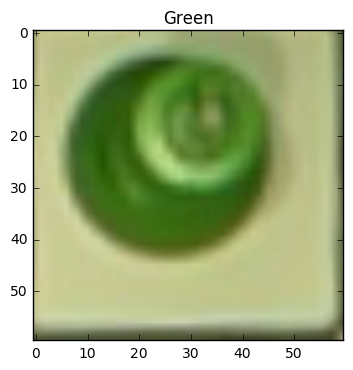

In [5]:
plot_image(4)

## Solving the Problem Using Color Masks

By isolating the green and orange colors and detecting whether that color exists in the image, we should be able to determine if there is a piece on a square.

In [6]:
x_kern = np.arange(0, 4, 1, float)
y_kern = x_kern[:,np.newaxis]
x_kern0 = y_kern0 = 4 // 2
OPENING_KERNEL = np.uint8(np.exp(-4*np.log(2) * ((x_kern-x_kern0)**2 + (y_kern-y_kern0)**2) / 2**2) * 255)

def mask(img, lower, upper):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, OPENING_KERNEL)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, OPENING_KERNEL)
    return closing

In [7]:
# HSV Color Ranges
GREEN_LOWER = (40,100,45)
GREEN_UPPER = (120,255,255)
ORANGE_LOWER = (0,100,64)
ORANGE_UPPER = (20,255,255)

def green_mask(img):
    return mask(img, GREEN_LOWER, GREEN_UPPER)

def orange_mask(img):
    return mask(img, ORANGE_LOWER, ORANGE_UPPER)

def combined_mask(img):
    return green_mask(img) + orange_mask(img)

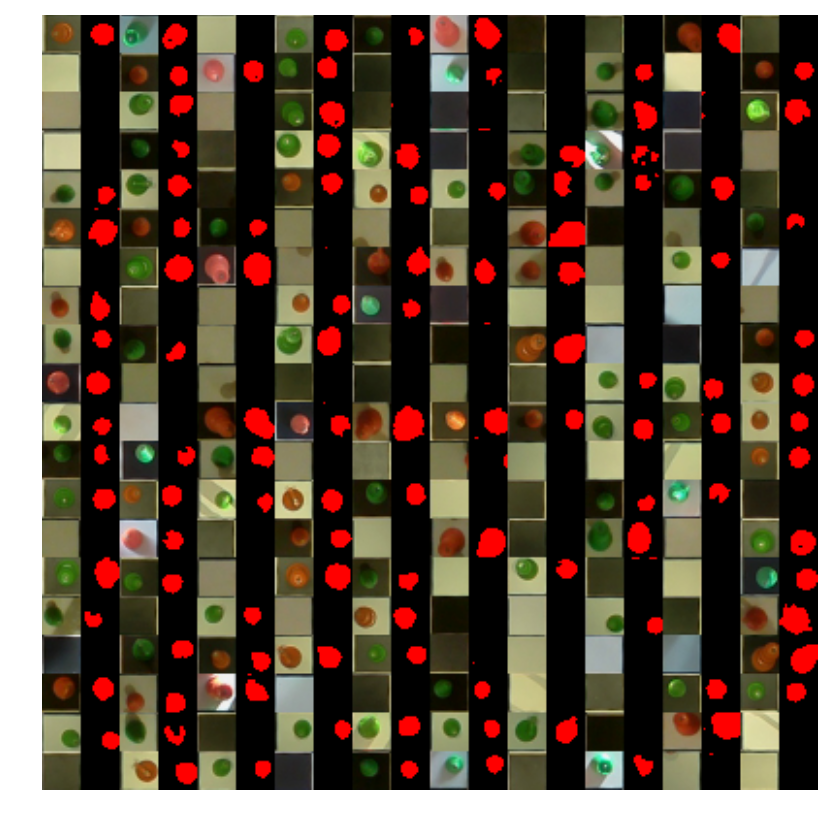

In [8]:
c = np.zeros((400, 400, 3), dtype=np.uint8)
start_index = 1000
for i in range(start_index, start_index + 200):
    img = imgs[i]
    mask_img = cv2.bitwise_or(green_mask(img), orange_mask(img))
    x = (i % 10) * 40
    y = ((i % 200) / 10) * 20
    c[y:y+20,x:x+20,:] = cv2.resize(img, (20,20))
    c[y:y+20,x+20:x+40,0] = cv2.resize(mask_img, (20,20))
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(c)
plt.show()

### Prediction

If the there a certain number of pixels in the image that are within the color range, there is assumed to be a piece in that square.

In [9]:
def predict(img):
    threshold = 5.0
    if np.sum(green_mask(img)) > threshold:
        return 1
    elif np.sum(orange_mask(img)) > threshold:
        return 2
    else:
        return 0

### Validation

The validation data is used to test the accuracy of the prediction model.

In [10]:
pred = [predict(img) for img in validation_imgs]
a = np.sum(pred == d.y_val) / float(d.y_val.shape[0])
print "Accuracy: {}".format(a)

Accuracy: 0.953051643192


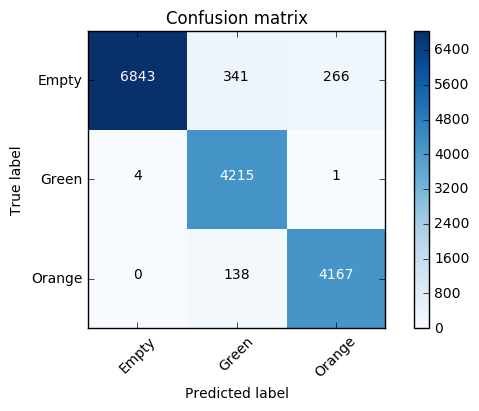

In [11]:
from sklearn.metrics import confusion_matrix
from helpers import plot_confusion_matrix

conf = confusion_matrix(d.y_val, pred)
plot_confusion_matrix(conf, classes=label_names)

### Improving Prediction

Some pieces that are very close to the edge of their square occasionally appear in the sides of square next to it. The model should be updated to only base prediction on pixels within the color range that located towards the center of the image since that's were the piece will be.

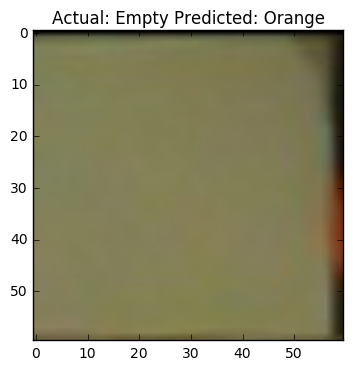

In [12]:
image_index = 405
actual_label = label_names[d.y_val[image_index]]
predicted_label = label_names[predict(validation_imgs[image_index])]
title = "Actual: {} Predicted: {}".format(actual_label, predicted_label)
plot_image(image_index, validation=True, title=title)

In [13]:
size = imgs.shape[1]
x = np.arange(0, size, 1, float)
y = x[:,np.newaxis]
x0 = y0 = size // 2
MASK_WEIGHTS = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / (size*0.15)**2)

def weighted_orange_mask(img):
    return orange_mask(img) * MASK_WEIGHTS

def weighted_green_mask(img):
    return green_mask(img) * MASK_WEIGHTS

def weighted_predict(img):
    threshold = 5.0
    if np.sum(weighted_green_mask(img)) > threshold:
        return 1
    elif np.sum(weighted_orange_mask(img)) > threshold:
        return 2
    else:
        return 0

In [14]:
weighted_pred = [weighted_predict(img) for img in validation_imgs]
a = np.sum(weighted_pred == d.y_val) / float(d.y_val.shape[0])
print "Accuracy: {}".format(a)

Accuracy: 0.997496087637


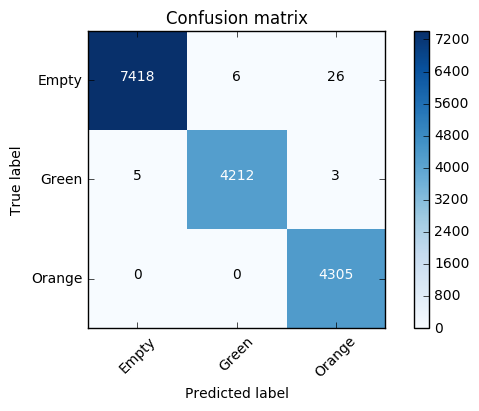

In [15]:
conf = confusion_matrix(d.y_val, weighted_pred)
plot_confusion_matrix(conf, classes=label_names)

## Solving the Problem Using Machine Learning

The next approach is to reduce the number of dimensions of each image by using PCA, and then building a support vector machine for classification.

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=16, whiten=True)
pca.fit(d.X_train)
X_train_pca = pca.transform(d.X_train)
X_val_pca = pca.transform(d.X_val)

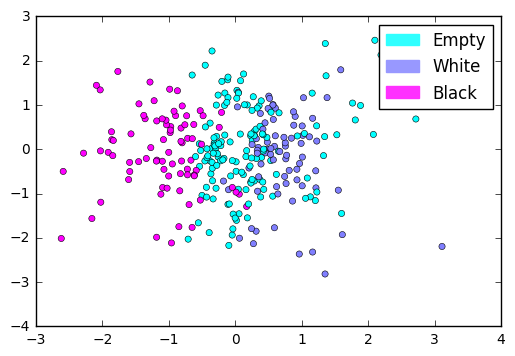

In [17]:
from matplotlib import cm
from matplotlib.patches import Patch

X_plot = X_train_pca[:300]
y_plot = d.y_train[:300]

sc = plt.scatter(X_plot[:,4], X_plot[:,8], c=y_plot, cmap=cm.cool, linewidths=0.4)
occupied_patch = Patch(color='#ff30ff', label='Occupied')
empty_patch = Patch(color='#30ffff', label='Empty')
white_patch = Patch(color='#9898FF', label='White')
black_patch = Patch(color='#ff30ff', label='Black')
plt.legend(handles=[empty_patch, white_patch, black_patch])
plt.show()

In [18]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_pca, d.y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Validation

In [19]:
svc_pred = svc.predict(X_val_pca)
a = np.sum(svc_pred == d.y_val) / float(d.y_val.shape[0])
print "Accuracy: {}".format(a)

Accuracy: 0.999123630673


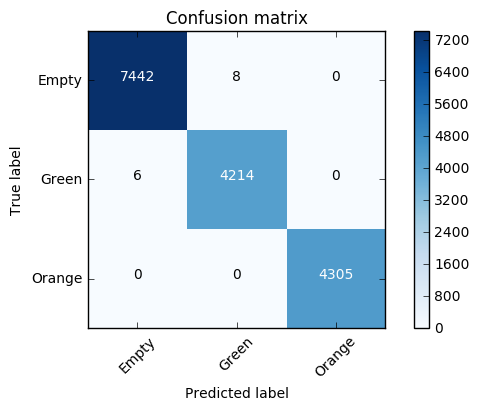

In [20]:
conf = confusion_matrix(d.y_val, svc_pred)
plot_confusion_matrix(conf, classes=label_names)

### Saving the Model

Save the PCA and SVC for use in the vision portion of the Raspberry Turk. The support vector machine had slightly higher accuracy on the validation set, and is easier to adapt/scale with the addition of new data (different lighting conditions, different colored pieces, different camera, etc). 

In [21]:
import pickle

with open(project.path('data', 'processed', 'square_color_detector3.pca'), 'w') as f:
    pickle.dump(pca, f)

with open(project.path('data', 'processed', 'square_color_detector3.svc'), 'w') as f:
    pickle.dump(svc, f)